## Plot ISOMIP Melt with thermo on

In [8]:
#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
from xgcm import Grid
import numpy as np
import pandas as pd
import cftime
import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import sys, os
import warnings
warnings.simplefilter("ignore")
from dask.distributed import Client

from xhistogram.xarray import histogram
import cmcrameri as cmc
from scipy.optimize import fsolve


In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/38751/status,
Dashboard: /proxy/38751/status,Workers: 7
Total threads: 7,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42041,Workers: 7
Dashboard: /proxy/38751/status,Total threads: 7
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:33227,Total threads: 1
Dashboard: /proxy/45269/status,Memory: 4.57 GiB
Nanny: tcp://127.0.0.1:35329,


In [4]:
list_folders_base = ['layer-thermo-on-warm_CC','layer-thermo-on-cold_CC',
               'layer-thermo-on-warm_SF','layer-thermo-on-cold_SF']
suffixes = ['','-ustarmin','-u01tides','-u005tides','-u001tides','-u02tides','-MK18']
list_folders = []
for n in np.arange(len(suffixes)):
    list_folders = np.append(list_folders, [x+suffixes[n] for x in list_folders_base])
print(list_folders)

base_folder_MOM6 = '/g/data/x77/cy8964/mom6/archive/'#'/scratch/x77/cy8964/mom6/archive/'
# base_folder = '/home/156/cy8964/mom6-control/isomip-control/ISOMIP-MOM6-examples/'
# base_folder
# suffix = '/archive'

base_folder = base_folder_MOM6
suffix = ''

['layer-thermo-on-warm_CC' 'layer-thermo-on-cold_CC'
 'layer-thermo-on-warm_SF' 'layer-thermo-on-cold_SF'
 'layer-thermo-on-warm_CC-ustarmin' 'layer-thermo-on-cold_CC-ustarmin'
 'layer-thermo-on-warm_SF-ustarmin' 'layer-thermo-on-cold_SF-ustarmin'
 'layer-thermo-on-warm_CC-u01tides' 'layer-thermo-on-cold_CC-u01tides'
 'layer-thermo-on-warm_SF-u01tides' 'layer-thermo-on-cold_SF-u01tides'
 'layer-thermo-on-warm_CC-u005tides' 'layer-thermo-on-cold_CC-u005tides'
 'layer-thermo-on-warm_SF-u005tides' 'layer-thermo-on-cold_SF-u005tides'
 'layer-thermo-on-warm_CC-u001tides' 'layer-thermo-on-cold_CC-u001tides'
 'layer-thermo-on-warm_SF-u001tides' 'layer-thermo-on-cold_SF-u001tides'
 'layer-thermo-on-warm_CC-u02tides' 'layer-thermo-on-cold_CC-u02tides'
 'layer-thermo-on-warm_SF-u02tides' 'layer-thermo-on-cold_SF-u02tides'
 'layer-thermo-on-warm_CC-MK18' 'layer-thermo-on-cold_CC-MK18'
 'layer-thermo-on-warm_SF-MK18' 'layer-thermo-on-cold_SF-MK18']


In [5]:
## define some useful functions
ymax = 720
def open_files(i):
    base = base_folder + list_folders[i] +suffix
    try:
        prog = xr.open_dataset(base + '/output000/prog__0001_002.nc')
    except FileNotFoundError:
        prog = xr.open_dataset(base + '/output000/prog__0001_001.nc')
    #ocean_daily_z = xr.open_dataset(base + 'output000/ocean_daily_z.nc')
    ocean_geometry = xr.open_dataset(base + "/output000/ocean_geometry.nc")
    return prog, ocean_geometry
def open_files2(i):
    base = base_folder + list_folders[i] +suffix
    prog = xr.open_dataset(base + '/output001/prog__0002_002.nc')
    #ocean_daily_z = xr.open_dataset(base + 'output000/ocean_daily_z.nc')
    ocean_geometry = xr.open_dataset(base + "/output001/ocean_static.nc")
    return prog, ocean_geometry
def open_fileshourly(i):
    base = base_folder + list_folders[i] +suffix
    prog = xr.open_dataset(base + '/output000/prog_hourly__0002_001.nc',chunks={'Time': 10}).chunk({'Time': 10,'yh':40,'xh':240,'yq':40,'xq':240})
    #ocean_daily_z = xr.open_dataset(base + 'output000/ocean_daily_z.nc')
    ocean_geometry = xr.open_dataset(base + "/output000/ocean_static.nc")
    return prog, ocean_geometry
def open_ocean_daily_z(i):
    base = base_folder + list_folders[i]+suffix
    prog = xr.open_dataset(base + '/output000/ocean_daily_z.nc')
    return prog
def open_ocean_daily_z2(i):
    base = base_folder + list_folders[i]+suffix
    prog = xr.open_dataset(base + '/output001/ocean_daily_z.nc')
    return prog
def plot(ax,yy0,tt,i,variable,varname,vmin1,vmax1,cmap):
    prog, ocean_static = open_files(i)
    grid = Grid(prog,coords={"x":{"center":"xh","outer":"xq"},
                             "y":{"center":"yh","outer":"yq"},
                             "z":{"center":"zl","outer":"zi"}},periodic=False)
    file_name = list_folders[i]
    label = file_name
    depth = grid.interp(prog.e,'x')
    lon = ocean_static.geolonb
    dataplot = variable

    xx = lon
    if varname == "uo": dataplot = dataplot[:,:,:,:-1]
    levels = np.linspace(vmin1, vmax1, 51)
    yy = depth[:,:,yy0,:]
    z_levels = yy.shape[1]
    yi = np.linspace(0,5000,z_levels) #Dummy, just for have z_levels
    # plot variable in colours
    xi, yyi = np.meshgrid(xx[yy0,:], yi) #We repeat the horizontal part of the grid by the number of zlevels
    #cax = ax.contourf(xi,yy[tt,...],dataplot[tt,:,yy0,:],levels = levels, cmap = cmap, extend = 'both',corner_mask = False)
    #print(xi.shape)
    #print(yy[tt,...].shape)
    #print(dataplot[tt,:,yy0,:].shape)
    cax = ax.pcolormesh(xi,yy[tt,...],dataplot[tt,:,yy0,:],vmin = vmin1, vmax = vmax1, cmap = cmap)
    
    plt.colorbar(cax, ax = ax, label = varname)
    
    ## plot interface heights
    i_heights = prog.e # this is 'Interface Height Relative to Mean Sea Level'
    # do for one time
    i_heights = i_heights.isel(Time = tt)
    # take zonal mean
    i_heights = i_heights.isel(yh = yy0)#.mean('xh')

    # plot a line of layer depths, layer by layer
    nz = len(i_heights.zi)
    xh = prog.xh

    for i in range(nz):
        ax.plot(xh,i_heights[i], color = 'k', linewidth = 0.5)
    
    ax.set_ylim(ymin=-ymax,ymax=0)
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel('x (km)')
    ax.set_title(varname+' , ' +label)
    

    
def plot_melt(ax,tt,i,vmin1,vmax1,cmap):
    ocean_daily_z = open_ocean_daily_z(i)
    file_name = list_folders[i]
    label = list_folders[i]
    s_to_year = 3600*24*365
    dataplot = ocean_daily_z.melt.isel(time = tt)#/1030/(2000)**2*s_to_year
    
    p1 = dataplot.plot(ax = ax, cmap = cmap, vmax = vmax1, vmin = vmin1, add_colorbar = False)
    plt.colorbar(p1, ax = ax, label = 'Melt, [m/yr]')
    ax.set_ylabel('Longitude')
    ax.set_xlabel('Latitude')
    ax.set_title('Melt , ' +label)
    print('Total Melt for '+label+' experiment = '+str(dataplot.sum().values)+' m/yr')
def plot_melt2(ax,tt,i,vmin1,vmax1,cmap):
    ocean_daily_z = open_ocean_daily_z2(i)
    file_name = list_folders[i]
    label = list_folders[i]
    s_to_year = 3600*24*365
    dataplot = ocean_daily_z.melt.isel(time = tt)#/1030/(2000)**2*s_to_year
    
    p1 = dataplot.plot(ax = ax, cmap = cmap, vmax = vmax1, vmin = vmin1, add_colorbar = False)
    plt.colorbar(p1, ax = ax, label = 'Melt, [m/yr]')
    ax.set_ylabel('Longitude')
    ax.set_xlabel('Latitude')
    ax.set_title('Melt , ' +label)
    print('Total Melt for '+label+' experiment = '+str(dataplot.sum().values)+' m/yr')

def plot_normalised_melt(ax,tt,i,vmin1,vmax1,cmap):
    ocean_daily_z = open_ocean_daily_z(i)
    file_name = list_folders[i]
    label = list_folders[i]
    s_to_year = 3600*24*365
    total_melt = ocean_daily_z.melt.isel(time = tt).sum().values # all grid boxes same size
    dataplot = ocean_daily_z.melt.isel(time = tt)/total_melt#/1030/(2000)**2*s_to_year
    
    p1 = dataplot.plot(ax = ax, cmap = cmap, vmax = vmax1, vmin = vmin1, add_colorbar = False)
    plt.colorbar(p1, ax = ax, label = 'Melt, [m/yr]')
    ax.set_ylabel('Longitude')
    ax.set_xlabel('Latitude')
    ax.set_title('Normalised Melt , ' +label)
    print('Total Melt for '+label+' experiment = '+str(total_melt)+' m/yr')


def plot_Lplus(ax,tt,i,vmin1,vmax1,cmap):
    ocean_daily_z = open_ocean_daily_z(i)
    file_name = list_folders[i]
    label = list_folders[i]
    s_to_year = 3600*24*365
    dataplot = ocean_daily_z.Lplus.isel(time = tt)#/1030/(2000)**2*s_to_year
    
    p1 = np.log10(dataplot).plot(ax = ax, cmap = cmap, vmax = vmax1, vmin = vmin1, add_colorbar = False)
    plt.colorbar(p1, ax = ax, label = '$\log_{10}L^+$')
    np.log10(dataplot).plot.contourf(ax = ax, levels = [0,np.log10(2500)],colors='none', hatches=['...', None], add_colorbar = False)
    ax.set_ylabel('y [km]')
    ax.set_xlabel('x [km]')
    ax.set_title('$L^+$ , ' +label)

def find_KE(prog):
    # interpolate speeds to the same grid
    grid = Grid(prog,coords={"x":{"center":"xh","outer":"xq"},
                             "y":{"center":"yh","outer":"yq"},
                             "z":{"center":"zl","outer":"zi"}},periodic=False)
    uo_interp = grid.interp(prog.u,'x',boundary='extend')
    vo_interp = grid.interp(prog.v,'y',boundary='extend')
    KE = 0.5*(uo_interp**2+vo_interp**2)
    return KE

def plot_KE(ax,tt,i,vmin1,vmax1,cmap):
    prog, ocean_geometry = open_files(i)
    file_name = list_folders[i]
    label = list_folders[i]
    KE = find_KE(prog)
    dataplot = KE.isel(Time = tt).sum('zl')
    
    p1 = dataplot.plot(ax = ax, cmap = cmap, vmax = vmax1, vmin = vmin1, add_colorbar = False)
    plt.colorbar(p1, ax = ax, label = 'KE (1/2|u|^2), [m^2/s^2]')
    ax.set_ylabel('Longitude')
    ax.set_xlabel('Latitude')
    ax.set_title('KE , ' +label)
    print('Total KE for '+label+' experiment = '+str(dataplot.sum().values)+' m^2/s^2')
def plot_KE2(ax,tt,i,vmin1,vmax1,cmap):
    prog, ocean_geometry = open_files2(i)
    file_name = list_folders[i]
    label = list_folders[i]
    KE = find_KE(prog)
    dataplot = KE.isel(Time = tt).sum('zl')
    
    p1 = dataplot.plot(ax = ax, cmap = cmap, vmax = vmax1, vmin = vmin1, add_colorbar = False)
    plt.colorbar(p1, ax = ax, label = 'KE (1/2|u|^2), [m^2/s^2]')
    ax.set_ylabel('Longitude')
    ax.set_xlabel('Latitude')
    ax.set_title('KE , ' +label)
    print('Total KE for '+label+' experiment = '+str(dataplot.sum().values)+' m^2/s^2')
def plot_overturning(ax,yy0,tti,ttf,i,vmin1,vmax1,cmap):
    # since topography/ice shape varies with position, take zonal sum of overturning (in depth coordinate) and map onto zonal sum of layer depth
    prog, ocean_geometry = open_files(i)
    ocean_daily_z = open_ocean_daily_z(i)
    ocean_static = open_static(i)
    grid = Grid(prog,coords={"x":{"center":"xh","outer":"xq"},
                             "y":{"center":"yh","outer":"yq"},
                             "z":{"center":"zl","outer":"zi"}},periodic=False)    
    file_name = list_folders[i]
    label = list_folders[i]
    depth = ocean_daily_z.e
    lon = ocean_geometry.geolon

    vh = grid.interp(ocean_daily_z.vo,'y',boundary='extend')*ocean_daily_z.h
    uh = grid.interp(ocean_daily_z.uo,'x',boundary='extend')*ocean_daily_z.h
    Psi_overturning = (uh*ocean_static.dyt).cumsum('z_l').isel(time = np.arange(tti,ttf)).sum('yh', skipna = True).mean('time')

    dataplot = Psi_overturning/1e6

    xx = lon
    levels = np.linspace(-0.01,0.01, 51)
    yy = (depth[tti:ttf,:-1,:,:]).mean(['time','yh'], skipna = True)
    z_levels = yy.shape[0]
    yi = np.linspace(0,5000,z_levels) #Dummy, just for have z_levels
    # plot variable in colours
    xi, yyi = np.meshgrid(xx[0], yi) #We repeat the horizontal part of the grid by the number of zlevels
    cax = ax.contourf(xi,yy.fillna(0),dataplot,levels = levels, cmap = cmap)
    plt.colorbar(cax, ax = ax, label = 'Overturning [Sv]')

    #ax.set_ylim(ymin=-720,ymax=0)
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel('Latitude')
    ax.set_title('Overturning streamfunction,\n ' +label)
def plot_barotropic(ax,yy0,tti,ttf,i,vmin1,vmax1,cmap):
    prog, ocean_geometry = open_files(i)
    ocean_daily_z = open_ocean_daily_z(i)
    ocean_static = open_static(i)
    grid = Grid(prog,coords={"x":{"center":"xh","outer":"xq"},
                             "y":{"center":"yh","outer":"yq"},
                             "z":{"center":"zl","outer":"zi"}},periodic=False)    
    file_name = list_folders[i]
    label = list_folders[i]
    lon = ocean_geometry.geolon

    uh = grid.interp(ocean_daily_z.uo,'x',boundary='extend')*ocean_daily_z.h
    Psi_barotropic = (uh*ocean_static.dyt).cumsum('yh').sum('z_l').isel(time = np.arange(tti,ttf)).mean('time')
    
    dataplot = Psi_barotropic/1e6

    p1 = dataplot.plot(ax = ax, cmap = cmap, vmax = vmax1, vmin = vmin1, add_colorbar = False)
    plt.colorbar(p1, ax = ax, label = 'Barotropic streamfunction [Sv]')
    ax.set_ylabel('Longitude')
    ax.set_xlabel('Latitude')
    ax.set_title('Barotropic streamfunction,\n ' +label)
    
        

In [6]:
no_configs = len(list_folders)

Plot contours of melt rate too

<a list of 3 text.Text objects>

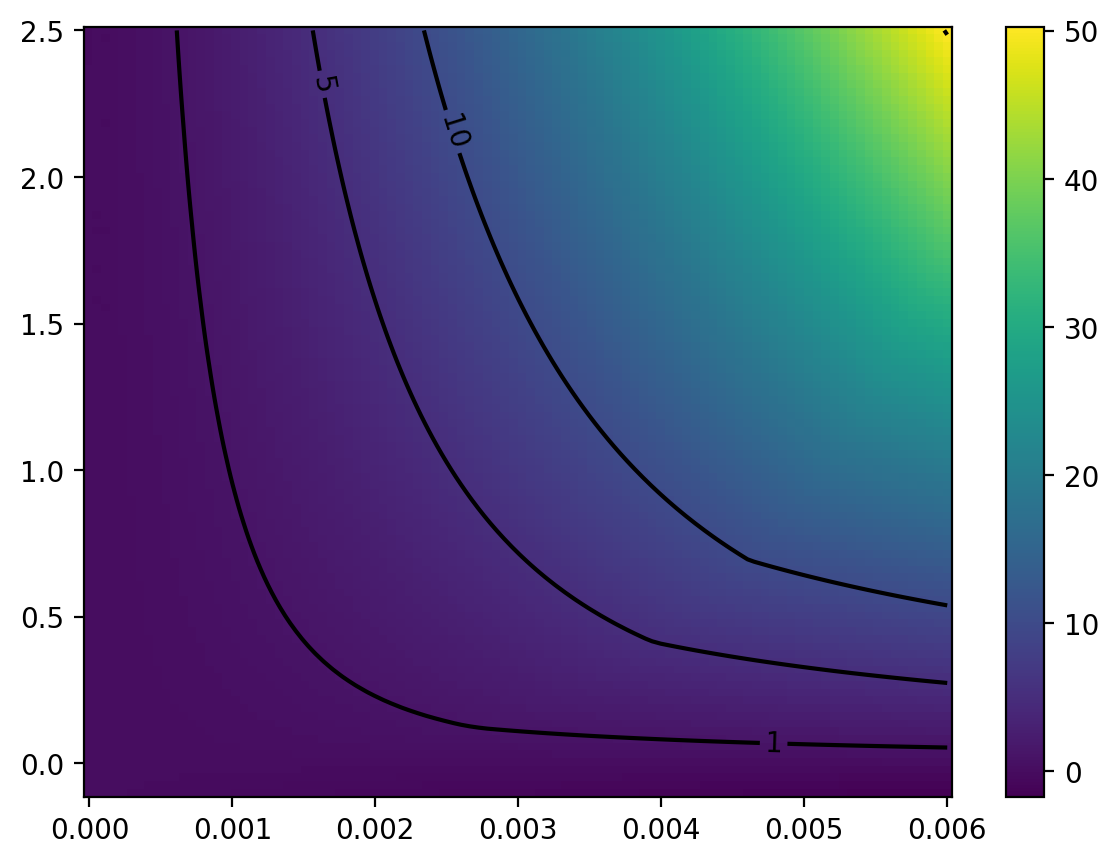

In [9]:
# python param
def Tfreeze(S,p):
    lam_1 = -0.0573 #Ckg/g (salinity)
    lam_2 = -7.53e-4 #C/dbar (pressure)
    lam_3 = 0.0826 # offset
    return lam_3+lam_1*S+lam_2*p
def solve_three_eqn_python_isomipcoeffs(ustar, depth, sst,
                    sss, J10_Gamma = True, Rosevear_Gamma = False, HJ99_Gamma = False, R22lim = False,
                                       MK18 = False, theta = 10, R22MK18 = False,HJ99_Gamma_M81 =False):
    
    R0 = 1030 #kg/m^3
    Cp = 3974 #J/K/kg
    lam_1 = -0.0573 #Ckg/g (salinity)
    lam_2 = -7.53e-4 #C/dbar (pressure)
    lam_3 = 0.0826 # offset
    L = 3.34e5 #J/kg
    Ri = 920 #kg/m^3
    g =9.81
    p = depth*R0*g #pascals p = rho*g*h for hydrostatic 
    p = p/1e4 #dbar
    I_VK = 1/0.41
    kv_molec = 2e-6
    dR0_dT = -0.0383569483 #[kg m-3 K-1] =alpha*R0
    dR0_dS = 0.805876093   #[kg m-3 PSU-1] =alpha*R0
    dB_dS = g/R0*dR0_dS
    dB_dT = g/R0*dR0_dT
    A =-9.89970135344883 #-9.29# -9.489
    B = 0.22260090020804837 #0.122 #0.155
    C = -7.3904118372660035 #-7.58 #-7.182
    D = 0.32220281249744703 #0.354 #0.290
    Lplus = 0
    def func(x):
        Tb,Sb,m = x
        return [Tb -lam_1*Sb-lam_2*p-lam_3,
                m - Cp/L*R0/Ri*Gam_T*ustar*(sst-Tb),
                m + R0/Ri*Gam_S*ustar*(Sb-sss)/Sb]
    def func2(x):
        Tb,Sb,m = x
        return [Tb -lam_1*Sb-lam_2*p-lam_3,
                m - Cp/L*R0/Ri*gamma_T*(sst-Tb),
                m + R0/Ri*gamma_S*(Sb-sss)/Sb] #uses gammaT, gammaS exchange VEL not coeff
    
    if J10_Gamma == True:
        Gam_T = 0.011
        Gam_S = 3.1e-4

        Tb,Sb,m = fsolve(func, [-1,30,-1])
        
    elif R22lim ==True:
        Gam_T = 0.012
        Gam_S = 3.9e-4

        Tb,Sb,m = fsolve(func, [-1,30,-1])
        
    elif Rosevear_Gamma == True:
        tolerance = 1e-4
        Gam_T = 0.012
        Gam_S = 3.9e-4

        Tb,Sb,m = fsolve(func, [-1,30,-1])
        Tb,Sb,m 
        #iterate to get convergent solution
        wB = dB_dS*(Sb-sss)*ustar*Gam_S + dB_dT*(Tb-sst)*ustar*Gam_T
        for i in np.arange(10):
            if (wB<0): #melting
                #print(i)
                Lplus = -ustar**4 * I_VK * 1.0/(kv_molec * wB)

                Gam_T = np.exp(C) * Lplus**(D) 
                Gam_S = np.exp(A) * Lplus**(B) 
                if Gam_T > 0.012:
                    Gam_T = 0.012
                if Gam_S > 3.9e-4:
                    Gam_S = 3.9e-4    
                Tb,Sb,m  = fsolve(func, [-1,30,1])
                wB = dB_dS*(Sb-sss)*ustar*Gam_S + dB_dT*(Tb-sst)*ustar*Gam_T
                Lplus_new = -ustar**4 * I_VK * 1.0/(kv_molec * wB)
                if np.abs(Lplus_new-Lplus) < tolerance:
                    break                    
            else:
                Tb,Sb,m = fsolve(func, [-1,30,1])
                break
                
    elif MK18 == True:
        Gam_T = 0.012
        Gam_S = 3.9e-4
        Tb,Sb,m = fsolve(func, [1,30,1]) # first get a preliminary Tb,Sb with SF Gamma's
        c_1 = 0.086
        kd_molec_salt = 8.02e-10 #m2 s-1
        kd_molec_temp = 1.41e-7 #m2 s-1
        
        for i in np.arange(10):
            gamma_T = c_1*(g*((sss-Sb)*dR0_dS+(sst-Tb)*dR0_dT)*kd_molec_salt**(1/2)/ \
                           (kv_molec*1030))**(1/3)*kd_molec_temp**(1/2)*np.sin(theta*np.pi/180)**(2/3)
            gamma_S = gamma_T*(Ri*Sb)/(R0*sss)*np.sqrt(kd_molec_salt/kd_molec_temp)

            Tb,Sb,m = fsolve(func2, [Tb,Sb,m])
            
    elif R22MK18 == True:
        tolerance = 1e-4
        Gam_T = 0.012
        Gam_S = 3.9e-4
        c_1 = 0.086
        kd_molec_salt = 8.02e-10 #m2 s-1
        kd_molec_temp = 1.41e-7 #m2 s-1

        Tb,Sb,m = fsolve(func, [-1,30,1])
        #iterate to get convergent solution
        wB = dB_dS*(Sb-sss)*ustar*Gam_S + dB_dT*(Tb-sst)*ustar*Gam_T
        for i in np.arange(30):
            if (wB<0): #melting
                #print(i)
                Lplus = -ustar**4 * I_VK * 1.0/(kv_molec * wB)

                Gam_T = np.exp(C) * Lplus**(D) 
                Gam_S = np.exp(A) * Lplus**(B) 
                if Gam_T > 0.012:
                    Gam_T = 0.012
                if Gam_S > 3.9e-4:
                    Gam_S = 3.9e-4    
                    
                #now choose max transfer coeff of R22 and MK18:
                gamma_T = max(Gam_T*ustar, c_1*(g*((sss-Sb)*dR0_dS+(sst-Tb)*dR0_dT)*kd_molec_salt**(1/2)/ \
                           (kv_molec*1030))**(1/3)*kd_molec_temp**(1/2)*np.sin(theta*np.pi/180)**(2/3))
                gamma_S = max(Gam_S*ustar, c_1*(g*((sss-Sb)*dR0_dS+(sst-Tb)*dR0_dT)*kd_molec_salt**(1/2)/ \
                           (kv_molec*1030))**(1/3)*kd_molec_temp**(1/2)*np.sin(theta*np.pi/180)**(2/3)*\
                              (Ri*Sb)/(R0*sss)*np.sqrt(kd_molec_salt/kd_molec_temp))

                Tb,Sb,m = fsolve(func2, [-1,30,1])
                
                wB = dB_dS*(Sb-sss)*gamma_S + dB_dT*(Tb-sst)*ustar*gamma_T
                Lplus_new = -ustar**4 * I_VK * 1.0/(kv_molec * wB)
                if np.abs(Lplus_new-Lplus) < tolerance:
                    break                    
            else:
                Tb,Sb,m = fsolve(func, [-1,30,-1])
                break
                
    elif HJ99_Gamma == True:
        Pr = 7.1
        Sc = 1239
        k = 0.41
        xiN = 0.052
        f = 0.000137
        h = 5*kv_molec/ustar
        eta = 1
        
        gamma_turb = 1/k*np.log(ustar*xiN/f/h*eta**2) + 1/(2*xiN*eta)-1/k
        
        gamma_T = ustar/(gamma_turb+12.5*Pr**(2/3)-6)
        gamma_S = ustar/(gamma_turb+12.5*Sc**(2/3)-6)
        
        Tb,Sb,m = fsolve(func2, [-1,30,1])
        
        Gam_T = gamma_T/ustar
        Gam_S = gamma_S/ustar

    elif HJ99_Gamma_M81 == True:
        gamma_T = 0.011*ustar
        gamma_S = 3.1e-4*ustar

        Tb,Sb,m = fsolve(func2, [-1,30,1]) #initial guess so we can calc buoyancy

        Pr = 7.1
        Sc = 1239
        k = 0.41
        xiN = 0.052
        f = 0.000137
        h = 5*kv_molec/ustar
        Rc = 0.2
        #eta = 1 # intial guess
        
        for i in np.arange(10):
            # iterate to match buoyancy/L/eta* with melt rate, Tb and Sb
            wB = dB_dS*(Sb-sss)*gamma_S + dB_dT*(Tb-sst)*gamma_T
            L_o = -ustar**3/k/wB
            if L_o>0:
                eta = (1 + xiN*ustar/f/Rc/L_o)**(-1/2)
            else:
                eta = 1
        
            gamma_turb = 1/k*np.log(ustar*xiN*eta**2/(f*h)) + 1/(2*xiN*eta)-1/k
        
            gamma_T = ustar/(gamma_turb+12.5*Pr**(2/3)-6)
            gamma_S = ustar/(gamma_turb+12.5*Sc**(2/3)-6)
        
            Tb,Sb,m = fsolve(func2, [-1,30,1])
            
        
        Gam_T = gamma_T/ustar
        Gam_S = gamma_S/ustar

    return Tb,Sb,m*365*3600*24,Gam_T,Gam_S,Lplus #Tb,Sb,m in m/yr

## test
sss = 34.05 #34.4 #34.05
p = 300
tfr = Tfreeze(sss,p)
# solve_three_eqn_python(0.001, 200*9.8*1030/100, -1.5,34,J10_Gamma = True, Rosevear_Gamma = False)
fig,ax = plt.subplots(figsize = (7,5),dpi = 200)
ustar_arr = np.linspace(-0.00001,0.006,100)
sst_arr = np.linspace(-0.1,2.5,100)+tfr
melt_arr = np.zeros([100,100])
Lplus_arr = np.zeros([100,100])
Tb_arr = np.zeros([100,100])
for m in np.arange(len(ustar_arr)):
    for n in np.arange(len(sst_arr)):
        #print(str(m)+', '+str(n))
        T,S,melt,Gam_T,Gam_S,Lplus = solve_three_eqn_python_isomipcoeffs(ustar_arr[m], depth =p,sst = sst_arr[n],
                                                 sss =sss,J10_Gamma = False, Rosevear_Gamma = True)
        melt_arr[m,n]=melt
        Lplus_arr[m,n]=Lplus
        Tb_arr[m,n] = T
plt.pcolormesh(ustar_arr,sst_arr-tfr,melt_arr.T)
plt.colorbar()

c1 = plt.contour(ustar_arr,np.maximum(sst_arr-tfr,sst_arr-Tb_arr[0,:]),melt_arr.T, levels = [1,5,10,50,100,200],colors = 'k')
plt.clabel(c1, c1.levels, inline=True, fontsize=10)


In [59]:
plt.rcParams['hatch.linewidth'] = 0.2


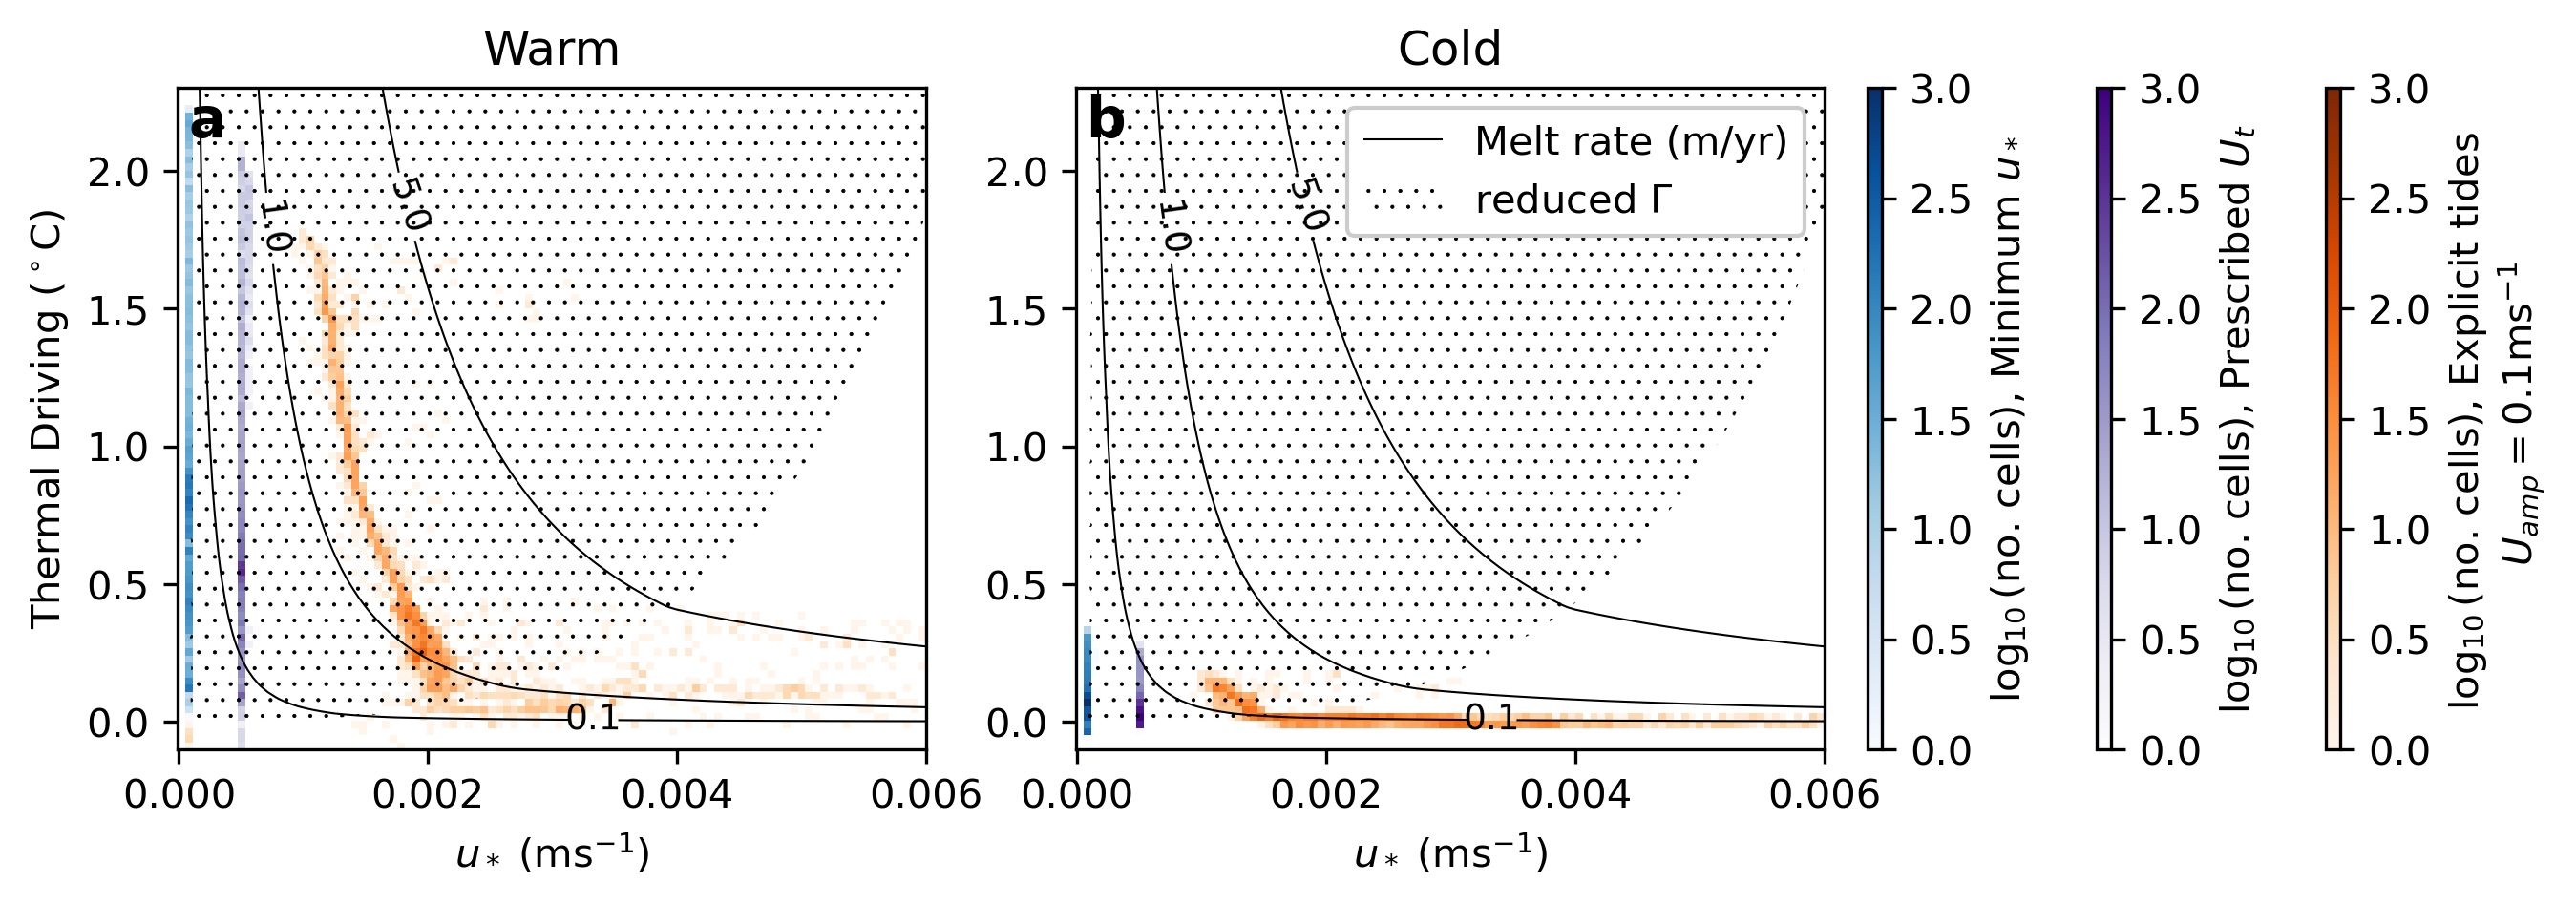

In [60]:

list_folders = [ 'layer-thermo-on-warm_SF-ustarmin',
                'layer-thermo-on-cold_SF-ustarmin',
                 'layer-thermo-on-warm_SF',
               'layer-thermo-on-cold_SF',
                'layer-thermo-on-warm_SF-u01tides',
            'layer-thermo-on-cold_SF-u01tides',
             ]                


fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,3), dpi = 300)

labels = ['Minimum $u_*$','Prescribed $U_t$', # 'Prescribed$U_t=0.01$ms$^{-1}$',
          # 'Min $u_*$ =1e-4ms$^{-1}$',
          'Explicit tides \n $U_{amp} = 0.1$ms$^{-1}$', #'Explicit tides $u_{amp} = 0.1$ms$^{-1}$',
         ]#, 'Very Cold ISOMIP+']

time_slice = np.arange(-180,0)
cd = 0.0025
for j in np.arange(3):#no_configs-4, no_configs):
    ocean_daily_z = open_ocean_daily_z(2*j)
    #cmap = [cm.cm.ice_r,cm.cm.rain,cm.cm.gray_r][j]
    #cmap = ['Blues','Purples','Greens'][j]
    cmap = ['Blues','Purples','Oranges'][j]
    #cmap = [cmc.cm.oslo_r,cmc.cm.lajolla_r,cmc.cm.buda_r][j]
    dt = ocean_daily_z.thermal_driving.isel(time = time_slice).mean('time')
    ustar = ocean_daily_z.ustar_shelf.isel(time = time_slice).mean('time')
    melt = ocean_daily_z.melt.isel(time = time_slice).mean('time')
    ubins = np.linspace(-0.00001,0.006,100)
    tbins = np.linspace(-0.1,2.5,100)
    hTS = histogram(dt, ustar, bins=[tbins, ubins], weights = melt.fillna(0))/histogram(dt, ustar, bins=[tbins, ubins])
    #hTS.T.plot(cmap = cm.cm.rain, ax = axes[j,0], cbar_kwargs={'label':'m/yr'})
    #axes[j,0].set_title('Melt Rate, '+list_folders[j])

    hTS = histogram(dt, ustar, bins=[tbins, ubins])#, weights = melt.fillna(0))/histogram(dt, ustar, bins=[tbins, ubins])
    np.log10(hTS).plot( cmap = cmap, ax = axes[0], vmin = 0, vmax = 3,add_colorbar = False)
                       #cbar_kwargs={'label':'$\log_{10}$(no. cells), '+labels[j]})
    if j == 2:
        axes[0].set_title('Warm')#+', constant $\Gamma_{T,S}$')
        CS5 = o2 = axes[0].contour(ustar_arr, sst_arr-tfr, melt_arr.T, levels = np.array([0.1,1,5]) , colors='k', linewidths = 0.5)
        axes[0].clabel(o2, fontsize=9, inline=True)
        CS6 = axes[0].contourf(ustar_arr, sst_arr-tfr, np.log10(Lplus_arr.T), levels = [0,np.log10(1e4)],colors='none', 
                  hatches=['...', None], 
                  extend='lower')
        h5,l1 = CS5.legend_elements()    
        h6,l1 = CS6.legend_elements()    
        #axes[0].legend([ h5[0],h6[0]], ['Melt rate (m/yr)','reduced $\Gamma$',], loc = 'upper right', framealpha=1)


    ocean_daily_z = open_ocean_daily_z(2*j+1)
    dt = ocean_daily_z.thermal_driving.isel(time = time_slice).mean('time')
    ustar = ocean_daily_z.ustar_shelf.isel(time = time_slice).mean('time')
    melt = ocean_daily_z.melt.isel(time = time_slice).mean('time')
    hTS = histogram(dt, ustar, bins=[tbins, ubins])#, weights = melt.fillna(0))/histogram(dt, ustar, bins=[tbins, ubins])
    cs = np.log10(hTS).plot( cmap = cmap, ax = axes[1], vmin = 0, vmax = 3,add_colorbar = False)
                      #,cbar_kwargs={'label':'$\log_{10}$(no. cells), '+labels[j]})
    cax = plt.axes([0.715+j*0.08,0.11,0.005,0.77])
    cbar = plt.colorbar(cs, cax = cax,label = '$\log_{10}$(no. cells), '+labels[j])

    if j == 2:
        axes[1].set_title('Cold')#+', R22')
        CS5 = o2 = axes[1].contour(ustar_arr, sst_arr-tfr, melt_arr.T, levels = np.array([0.1,1,5]) , colors='k', linewidths = 0.5)
        axes[1].clabel(o2, fontsize=9, inline=True)
        CS6 = axes[1].contourf(ustar_arr, sst_arr-tfr, np.log10(Lplus_arr.T), levels = [0,np.log10(1e4)],colors='none', 
                  hatches=['...', None], 
                  extend='lower')
        h5,l1 = CS5.legend_elements()    
        h6,l1 = CS6.legend_elements()    
        axes[1].legend([ h5[0],h6[0]], ['Melt rate (m/yr)','reduced $\Gamma$',], loc = 'upper right', framealpha=1)

    
    #plt.scatter(np.ndarray.flatten(dt.values),np.ndarray.flatten(ustar.values),np.ndarray.flatten(melt.values), label = list_folders[j])

    if j == 2:
        axes[0].set_ylabel('Thermal Driving ($^\circ$C)')
        axes[0].set_xlabel('$u_*$ (ms$^{-1}$)')
        axes[1].set_ylabel('')
        axes[1].set_xlabel('$u_*$ (ms$^{-1}$)')#plt.legend()
    

#plt.ylim(-0.0001,0.003)
#plt.xlim(-0.1,2)

axes[0].text(0.04,0.95,'a',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=axes[0].transAxes, fontsize = 14,color = 'k')
axes[1].text(0.04,0.95,'b',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=axes[1].transAxes, fontsize = 14,color = 'k')

axes[0].set_ylim(-0.1,2.3)
axes[1].set_ylim(-0.1,2.3)

fig.subplots_adjust(wspace = 0.2, right = 0.7)

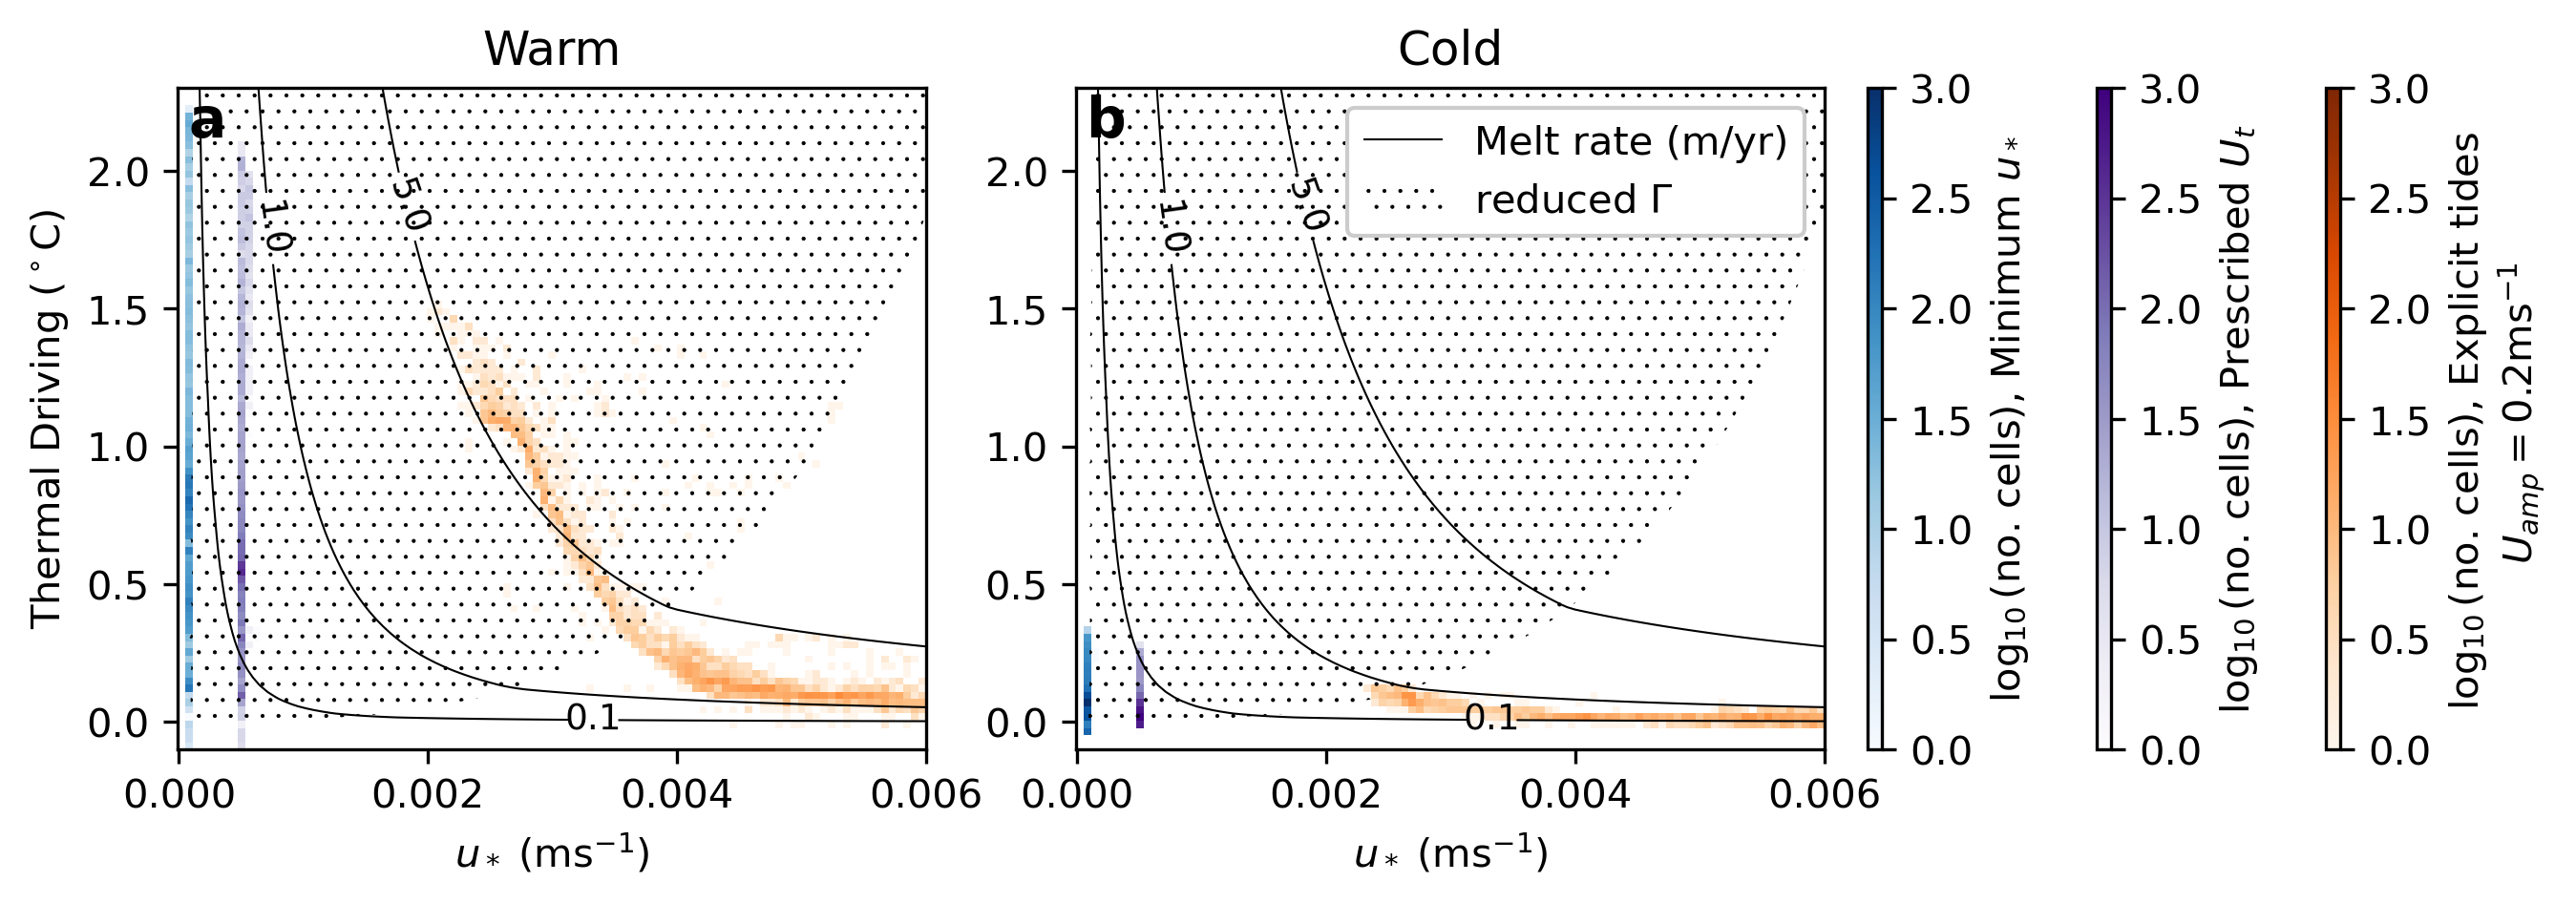

In [61]:

list_folders = [ 'layer-thermo-on-warm_SF-ustarmin',
                'layer-thermo-on-cold_SF-ustarmin',
                 'layer-thermo-on-warm_SF',
               'layer-thermo-on-cold_SF',
                'layer-thermo-on-warm_SF-u02tides',
            'layer-thermo-on-cold_SF-u02tides',
             ]                


fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,3), dpi = 300)

labels = ['Minimum $u_*$','Prescribed $U_t$', # 'Prescribed$U_t=0.01$ms$^{-1}$',
          # 'Min $u_*$ =1e-4ms$^{-1}$',
          'Explicit tides \n $U_{amp} = 0.2$ms$^{-1}$', #'Explicit tides $u_{amp} = 0.1$ms$^{-1}$',
         ]#, 'Very Cold ISOMIP+']

time_slice = np.arange(-180,0)
cd = 0.0025
for j in np.arange(3):#no_configs-4, no_configs):
    ocean_daily_z = open_ocean_daily_z(2*j)
    #cmap = [cm.cm.ice_r,cm.cm.rain,cm.cm.gray_r][j]
    #cmap = ['Blues','Purples','Greens'][j]
    cmap = ['Blues','Purples','Oranges'][j]
    #cmap = [cmc.cm.oslo_r,cmc.cm.lajolla_r,cmc.cm.buda_r][j]
    dt = ocean_daily_z.thermal_driving.isel(time = time_slice).mean('time')
    ustar = ocean_daily_z.ustar_shelf.isel(time = time_slice).mean('time')
    melt = ocean_daily_z.melt.isel(time = time_slice).mean('time')
    ubins = np.linspace(-0.00001,0.006,100)
    tbins = np.linspace(-0.1,2.5,100)
    hTS = histogram(dt, ustar, bins=[tbins, ubins], weights = melt.fillna(0))/histogram(dt, ustar, bins=[tbins, ubins])
    #hTS.T.plot(cmap = cm.cm.rain, ax = axes[j,0], cbar_kwargs={'label':'m/yr'})
    #axes[j,0].set_title('Melt Rate, '+list_folders[j])

    hTS = histogram(dt, ustar, bins=[tbins, ubins])#, weights = melt.fillna(0))/histogram(dt, ustar, bins=[tbins, ubins])
    np.log10(hTS).plot( cmap = cmap, ax = axes[0], vmin = 0, vmax = 3,add_colorbar = False)
                       #cbar_kwargs={'label':'$\log_{10}$(no. cells), '+labels[j]})
    if j == 2:
        axes[0].set_title('Warm')#+', constant $\Gamma_{T,S}$')
        CS5 = o2 = axes[0].contour(ustar_arr, sst_arr-tfr, melt_arr.T, levels = np.array([0.1,1,5]) , colors='k', linewidths = 0.5)
        axes[0].clabel(o2, fontsize=9, inline=True)
        CS6 = axes[0].contourf(ustar_arr, sst_arr-tfr, np.log10(Lplus_arr.T), levels = [0,np.log10(1e4)],colors='none', 
                  hatches=['...', None], 
                  extend='lower')
        h5,l1 = CS5.legend_elements()    
        h6,l1 = CS6.legend_elements()    
        #axes[0].legend([ h5[0],h6[0]], ['Melt rate (m/yr)','reduced $\Gamma$',], loc = 'upper right', framealpha=1)


    ocean_daily_z = open_ocean_daily_z(2*j+1)
    dt = ocean_daily_z.thermal_driving.isel(time = time_slice).mean('time')
    ustar = ocean_daily_z.ustar_shelf.isel(time = time_slice).mean('time')
    melt = ocean_daily_z.melt.isel(time = time_slice).mean('time')
    hTS = histogram(dt, ustar, bins=[tbins, ubins])#, weights = melt.fillna(0))/histogram(dt, ustar, bins=[tbins, ubins])
    cs = np.log10(hTS).plot( cmap = cmap, ax = axes[1], vmin = 0, vmax = 3,add_colorbar = False)
                      #,cbar_kwargs={'label':'$\log_{10}$(no. cells), '+labels[j]})
    cax = plt.axes([0.715+j*0.08,0.11,0.005,0.77])
    cbar = plt.colorbar(cs, cax = cax,label = '$\log_{10}$(no. cells), '+labels[j])

    if j == 2:
        axes[1].set_title('Cold')#+', R22')
        CS5 = o2 = axes[1].contour(ustar_arr, sst_arr-tfr, melt_arr.T, levels = np.array([0.1,1,5]) , colors='k', linewidths = 0.5)
        axes[1].clabel(o2, fontsize=9, inline=True)
        CS6 = axes[1].contourf(ustar_arr, sst_arr-tfr, np.log10(Lplus_arr.T), levels = [0,np.log10(1e4)],colors='none', 
                  hatches=['...', None], 
                  extend='lower')
        h5,l1 = CS5.legend_elements()    
        h6,l1 = CS6.legend_elements()    
        axes[1].legend([ h5[0],h6[0]], ['Melt rate (m/yr)','reduced $\Gamma$',], loc = 'upper right', framealpha=1)

    
    #plt.scatter(np.ndarray.flatten(dt.values),np.ndarray.flatten(ustar.values),np.ndarray.flatten(melt.values), label = list_folders[j])

    if j == 2:
        axes[0].set_ylabel('Thermal Driving ($^\circ$C)')
        axes[0].set_xlabel('$u_*$ (ms$^{-1}$)')
        axes[1].set_ylabel('')
        axes[1].set_xlabel('$u_*$ (ms$^{-1}$)')#plt.legend()
    

#plt.ylim(-0.0001,0.003)
#plt.xlim(-0.1,2)

axes[0].text(0.04,0.95,'a',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=axes[0].transAxes, fontsize = 14,color = 'k')
axes[1].text(0.04,0.95,'b',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=axes[1].transAxes, fontsize = 14,color = 'k')

axes[0].set_ylim(-0.1,2.3)
axes[1].set_ylim(-0.1,2.3)

fig.subplots_adjust(wspace = 0.2, right = 0.7)

# Investigate velocities due to tides at shelf

### Mean amplitude

layer-thermo-on-warm_R22limexdiags-u02tides
0.13546057
layer-thermo-on-warm_R22limexdiags-u01tides
0.053603683
layer-thermo-on-warm_R22limexdiags-u005tides
0.023582561
layer-thermo-on-warm_R22limexdiags-u001tides
0.0041409633


Text(0, 0.5, 'y (km)')

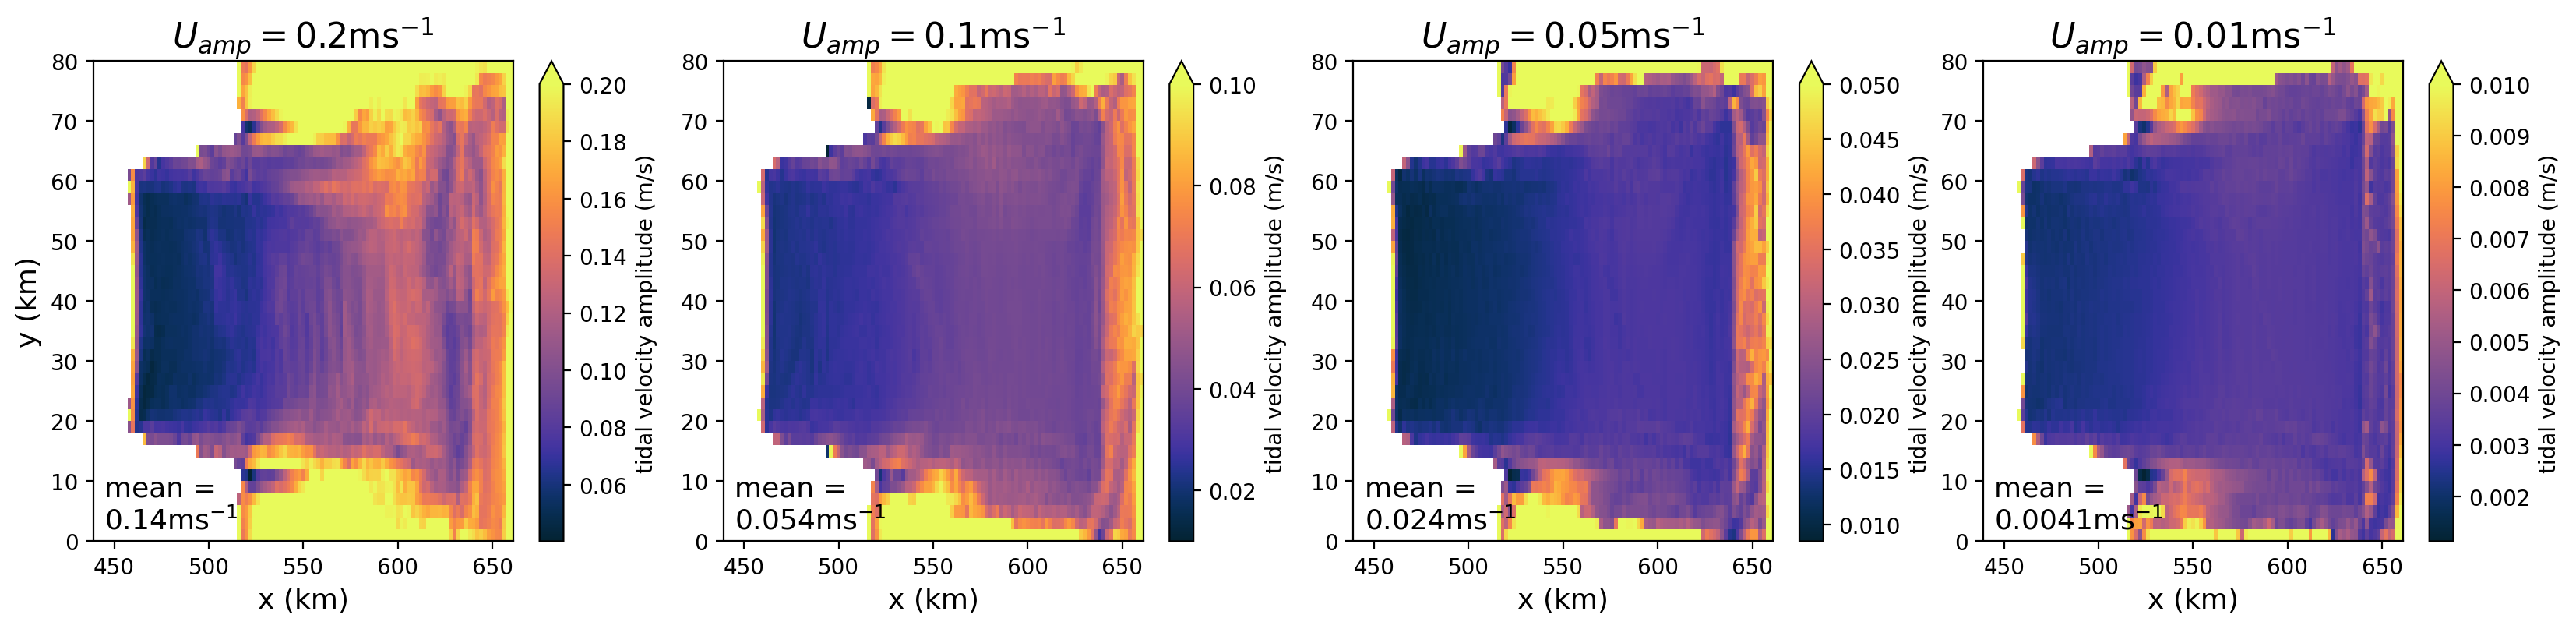

In [23]:
list_folders = [ 'layer-thermo-on-warm_R22limexdiags-u02tides',
             'layer-thermo-on-warm_R22limexdiags-u01tides',
               'layer-thermo-on-warm_R22limexdiags-u005tides',
               'layer-thermo-on-warm_R22limexdiags-u001tides']                

fig, axes = plt.subplots(ncols = 4, figsize = (20,4),dpi = 200)
for i in np.arange(4):
    umax = [0.2,0.1,0.05,0.01][i]
    prog, ocean_geometry = open_files(i)
    print(list_folders[i])
    
    max_u_vel = prog.u.isel(zl = 0,Time = np.arange(-24*30,0)).sel(xq  = slice(440,660)).groupby('Time.dayofyear').max('Time')
    max_u_vel
    min_u_vel = prog.u.isel(zl = 0,Time = np.arange(-24*30,0)).sel(xq  = slice(440,660)).groupby('Time.dayofyear').min('Time')
    min_u_vel
    
    max_amp = np.abs((max_u_vel-min_u_vel)/2).max('dayofyear')
    max_amp.load()
    print(max_amp.where(max_amp > 0.0001).mean().values)
    max_amp.where(max_amp > 0.0001).plot(ax = axes[i], vmax = umax, cmap = cm.cm.thermal,
                                   cbar_kwargs = {'label':'tidal velocity amplitude (m/s)'})
    axes[i].set_ylabel('')
    axes[i].set_xlabel('x (km)',fontsize = 13)
    axes[i].set_title('$U_{amp} = $'+str(umax)+'ms$^{-1}$',fontsize = 16)
    axes[i].text(445,2,'mean = \n'+f'{max_amp.where(max_amp > 0.0001).mean().values:.2}'+'ms$^{-1}$',fontsize = 13)
axes[0].set_ylabel('y (km)',fontsize = 13)


# Mean RMS

rms_vel_tidal = sqrt((u_tide - u_mean)**2+(v_tide - v_mean)**2)

layer-thermo-on-warm_CC-u02tides
0.07338359
Mean Tidal RMS = 0.073ms$^{-1}$
layer-thermo-on-warm_CC-u01tides
0.029529713
Mean Tidal RMS = 0.03ms$^{-1}$
layer-thermo-on-warm_CC-u005tides
0.013054706
Mean Tidal RMS = 0.013ms$^{-1}$
layer-thermo-on-warm_CC-u001tides
0.002512157
Mean Tidal RMS = 0.0025ms$^{-1}$


Text(0.04, 0.95, 'd')

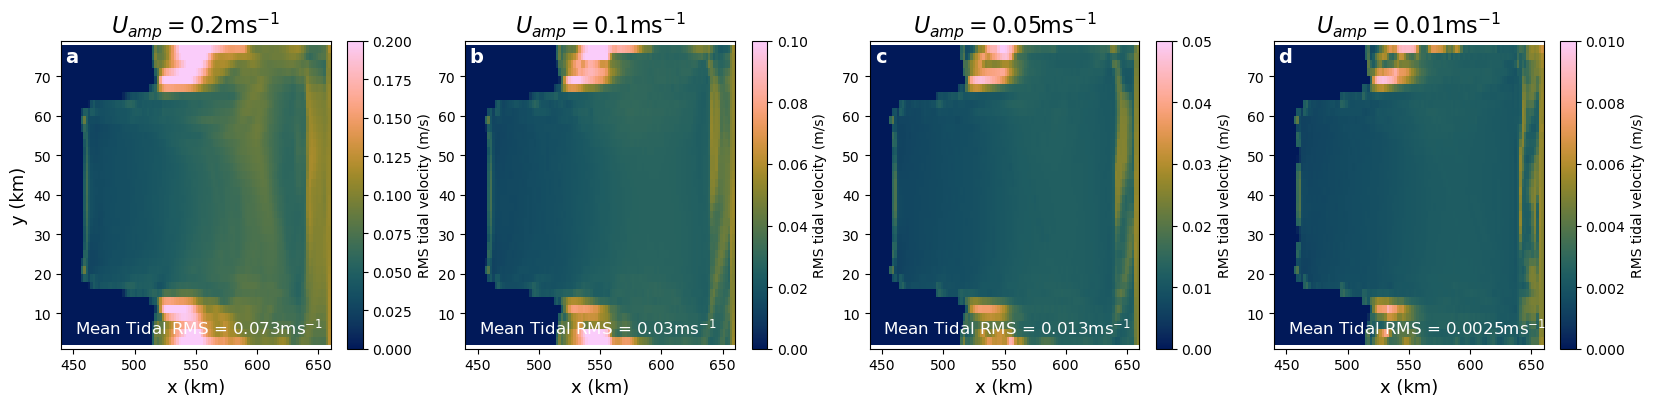

In [6]:
list_folders = [ 'layer-thermo-on-warm_CC-u02tides',
             'layer-thermo-on-warm_CC-u01tides',
               'layer-thermo-on-warm_CC-u005tides',
               'layer-thermo-on-warm_CC-u001tides']                

fig, axes = plt.subplots(ncols = 4, figsize = (20,4))
for i in np.arange(4):
    umax = [0.2,0.1,0.05,0.01][i]
    prog, ocean_geometry = open_fileshourly(i)
    print(list_folders[i])

    u = prog.u.isel(zl = 0,Time = np.arange(-24*30,0)).sel(xq  = slice(440,660))
    v = prog.v.isel(zl = 0,Time = np.arange(-24*30,0)).sel(xh  = slice(440,660))
    
    u = 0.5*(u + u.roll(xq = -1)).isel(xq = np.arange(110))
    v = 0.5*(v + v.roll(yq = -1)).isel(yq = np.arange(40))
    
    mean_u_vel = u.mean('Time')
    mean_v_vel = v.mean('Time')

    mean_u_vel= mean_u_vel.load()
    mean_v_vel= mean_v_vel.load()
    
    dusquared = ((u-mean_u_vel)**2).mean('Time')
    dvsquared = ((v-mean_v_vel)**2).mean('Time')

    dusquared = dusquared.load()
    dvsquared = dvsquared.load()
    
    RMS = np.sqrt(dusquared.values+ dvsquared.values)/np.sqrt(2)
    cs = axes[i].pcolormesh(prog.xq.sel(xq  = slice(440,660)).values,prog.yq.values,RMS,vmax = umax, cmap = cmc.cm.batlow)
    plt.colorbar(cs, ax = axes[i], label = 'RMS tidal velocity (m/s)')
    # max_amp.where(max_amp > 0.0001).plot(ax = axes[i], vmax = umax, cmap = cm.cm.thermal,
    #                                    cbar_kwargs = {'label':'RMS tidal velocity (m/s)'})
    axes[i].set_ylabel('')
    axes[i].set_xlabel('x (km)',fontsize = 13)
    axes[i].set_title('$U_{amp} = $'+str(umax)+r'ms$^{-1}$',fontsize = 16)
    print(np.nanmean(np.where(RMS>1e-4,RMS,np.nan)))
    print('Mean Tidal RMS = '+f'{np.nanmean(np.where(RMS>1e-4,RMS,np.nan)):.2}'+r'ms$^{-1}$')
    axes[i].text(0.05,0.05,'Mean Tidal RMS = '+f'{np.nanmean(np.where(RMS>1e-4,RMS,np.nan)):.2}'+r'ms$^{-1}$',
                 fontsize = 12,color = 'w',transform=axes[i].transAxes)
    axes[i].set_ylim(1,79)
axes[0].set_ylabel('y (km)',fontsize = 13)

axes[0].text(0.04,0.95,'a',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=axes[0].transAxes, fontsize = 14,color = 'w')
axes[1].text(0.04,0.95,'b',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=axes[1].transAxes, fontsize = 14,color = 'w')
axes[2].text(0.04,0.95,'c',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=axes[2].transAxes, fontsize = 14,color = 'w')
axes[3].text(0.04,0.95,'d',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=axes[3].transAxes, fontsize = 14,color = 'w')


layer-thermo-on-warm_CC-u02tides
0.103870936
Mean Tidal RMS = 0.1ms$^{-1}$
layer-thermo-on-warm_CC-u01tides
0.041798424
Mean Tidal RMS = 0.042ms$^{-1}$
layer-thermo-on-warm_CC-u005tides
0.018506322
Mean Tidal RMS = 0.019ms$^{-1}$
layer-thermo-on-warm_CC-u001tides
0.003531034
Mean Tidal RMS = 0.0035ms$^{-1}$
CPU times: user 2min 2s, sys: 8 s, total: 2min 10s
Wall time: 5min 14s


Text(0.04, 0.95, 'd')

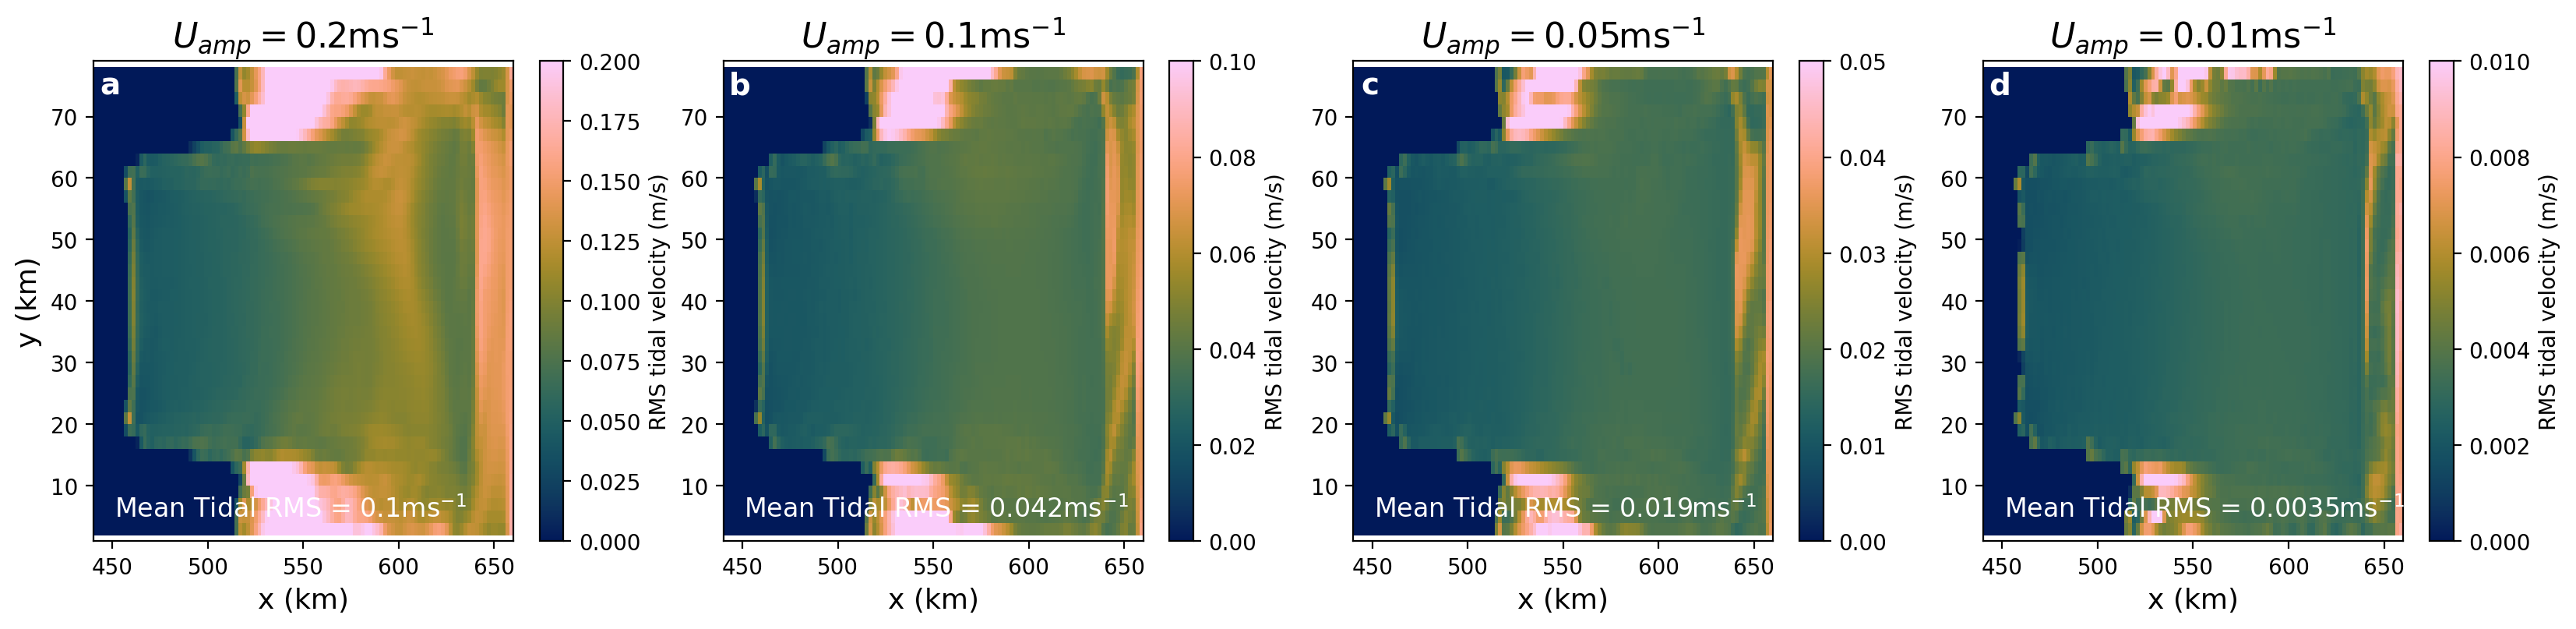

In [7]:
%%time
list_folders = [ 'layer-thermo-on-warm_CC-u02tides',
             'layer-thermo-on-warm_CC-u01tides',
               'layer-thermo-on-warm_CC-u005tides',
               'layer-thermo-on-warm_CC-u001tides']                

fig, axes = plt.subplots(ncols = 4, figsize = (20,4),dpi = 200)
for i in np.arange(4):
    print(list_folders[i])
    umax = [0.2,0.1,0.05,0.01][i]
    prog, ocean_geometry = open_fileshourly(i)

    u = prog.u.isel(zl = 0,Time = np.arange(-24*180,0)).sel(xq  = slice(440,660))
    v = prog.v.isel(zl = 0,Time = np.arange(-24*180,0)).sel(xh  = slice(440,660))
    
    u = 0.5*(u + u.roll(xq = -1)).isel(xq = np.arange(110))
    v = 0.5*(v + v.roll(yq = -1)).isel(yq = np.arange(40))
    
    mean_u_vel = u.mean('Time')
    mean_v_vel = v.mean('Time')

    mean_u_vel= mean_u_vel.load()
    mean_v_vel= mean_v_vel.load()
    
    dusquared = ((u-mean_u_vel)**2).mean('Time')
    dvsquared = ((v-mean_v_vel)**2).mean('Time')

    dusquared = dusquared.load()
    dvsquared = dvsquared.load()
    
    RMS = np.sqrt(dusquared.values+ dvsquared.values)
    #save values since it takes ages to compute
    np.savetxt('/home/156/cy8964/x77/ISOMIP/param-paper-plots/processed/RMS_180d_'+list_folders[i]+'.txt', RMS)
    cs = axes[i].pcolormesh(prog.xq.sel(xq  = slice(440,660)).values,prog.yq.values,RMS,vmax = umax, cmap = cmc.cm.batlow)
    plt.colorbar(cs, ax = axes[i], label = 'RMS tidal velocity (m/s)')
    # max_amp.where(max_amp > 0.0001).plot(ax = axes[i], vmax = umax, cmap = cm.cm.thermal,
    #                                    cbar_kwargs = {'label':'RMS tidal velocity (m/s)'})
    axes[i].set_ylabel('')
    axes[i].set_xlabel('x (km)',fontsize = 13)
    axes[i].set_title('$U_{amp} = $'+str(umax)+r'ms$^{-1}$',fontsize = 16)
    print(np.nanmean(np.where(RMS>1e-4,RMS,np.nan)))
    print('Mean Tidal RMS = '+f'{np.nanmean(np.where(RMS>1e-4,RMS,np.nan)):.2}'+r'ms$^{-1}$')
    axes[i].text(0.05,0.05,'Mean Tidal RMS = '+f'{np.nanmean(np.where(RMS>1e-4,RMS,np.nan)):.2}'+r'ms$^{-1}$',
                 fontsize = 12,color = 'w',transform=axes[i].transAxes)
    axes[i].set_ylim(1,79)
axes[0].set_ylabel('y (km)',fontsize = 13)

axes[0].text(0.04,0.95,'a',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=axes[0].transAxes, fontsize = 14,color = 'w')
axes[1].text(0.04,0.95,'b',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=axes[1].transAxes, fontsize = 14,color = 'w')
axes[2].text(0.04,0.95,'c',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=axes[2].transAxes, fontsize = 14,color = 'w')
axes[3].text(0.04,0.95,'d',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=axes[3].transAxes, fontsize = 14,color = 'w')
